In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
import cv2
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc 
from functools import reduce
import wfdb#https://github.com/MIT-LCP/wfdb-python
from wfdb import processing
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
torch.cuda.set_device(0)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


0


In [2]:
#Read data with List storage Name:[name],I:[img],Y[type]
def TypetoNum(itype): #map the type into number.
    if itype =='AMD': return 0
    elif itype =='DR': return 1
    elif itype =='glaucoma': return 2
    elif itype =='myopia': return 3
    else: return 4 #norm
    
root_dir = '/data/fjsdata/fundus/iSee/iSee_multi_dataset/' #the path of images
trainset = pd.read_csv("/data/fjsdata/fundus/iSee/iSee_multi_dataset/CBIR_iSee_train.csv" , sep=',')#load trainset
testset = pd.read_csv("/data/fjsdata/fundus/iSee/iSee_multi_dataset/CBIR_iSee_test.csv" , sep=',')#load testset
tstart = time.time()
#read train image with CV
trN, trI, trY = [],[],[]
norm = 6993
for iname, itype in np.array(trainset).tolist():
    if iname.endswith(".jpg"):
        try:
            image_dir = root_dir+'img_data_%s'%itype
            image_path = os.path.join(image_dir, iname)
            if itype == 'norm':
                if norm>0:
                    img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(1920,1920,3)->(256,256,3)
                    trN.append(iname)
                    trI.append(img)
                    trY.append(TypetoNum(itype))
                    norm = norm - 1
            else:
                img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(1920,1920,3)->(256,256,3)
                trN.append(iname)
                trI.append(img)
                trY.append(TypetoNum(itype))    
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(trN),trainset.shape[0]))
        sys.stdout.flush()
print('The length of train set is %d'%len(trN))
#read test image with CV
teN, teI, teY = [],[],[]
norm = 777
for iname, itype in np.array(testset).tolist():
    if iname.endswith(".jpg"):
        try:
            image_dir = root_dir+'img_data_%s'%itype
            image_path = os.path.join(image_dir, iname)
            if itype == 'norm':
                if norm>0:
                    img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(1920,1920,3)->(256,256,3)
                    teN.append(iname)
                    teI.append(img)
                    teY.append(TypetoNum(itype))
                    norm = norm - 1
            else:
                img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(1920,1920,3)->(256,256,3)
                teN.append(iname)
                teI.append(img)
                teY.append(TypetoNum(itype)) 
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(teN),testset.shape[0]))
        sys.stdout.flush()
print('The length of test set is %d'%len(teN))
elapsed = time.time() - tstart    
print('Completed data handle in %d seconds' % int(elapsed))

9000 / 9000 The length of train set is 9000
1000 / 1000 The length of test set is 1000
Completed data handle in 811 seconds


In [3]:
#ATH model with Tripet loss
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True) #resnet

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ATHNet(nn.Module):
    def __init__(self, hash_size: int, type_size: int):
        super().__init__()
        #resnet and maxpool
        self.net1 = nn.Sequential(#(3,256,256)->(16,128,128)
            ResBlock(in_channels=3, out_channels=16, stride=2), 
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )
        
        #Attention (16,128,128)->(16,128,128)
        self.sa = SpatialAttention()
        
        #resnet and meanpool
        self.net2 =nn.Sequential( #(16,128,128)->(8,64,64)
            ResBlock(in_channels=16, out_channels=8, stride=2),
            nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        ) 
         
        #fully connected with conv (8,64,64)->(1,32,32)
        self.dense=ResBlock(in_channels=8, out_channels=1, stride=2)
        #fully connected (1,32,32)->class_size
        self.hashlayer = nn.Linear(1*32*32, hash_size)
        self.typelayer = nn.Linear(1*32*32, type_size)
    
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net1(x)
        x = self.sa(x)*x
        x = self.net2(x)
        x = self.dense(x)
        x = x.view(x.size(0),-1)
        x_hash = self.hashlayer(x)
        x_type = self.typelayer(x)
        return x_hash, x_type

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#https://github.com/luyajie/triplet-deep-hash-pytorch#triplet-deep-hash-pytorch            
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
    
    def forward(self,H_q,H_p,H_n):    
        margin_val = self.margin * H_q.shape[1]
        squared_loss_pos = torch.mean(self.mse_loss(H_q, H_p), dim=1)
        squared_loss_neg = torch.mean(self.mse_loss(H_q, H_n), dim=1)
        zeros = torch.zeros_like(squared_loss_neg)
        loss  = torch.max(zeros, margin_val - squared_loss_neg + squared_loss_pos)
        return torch.mean(loss)
    
#Generate image pairs for model
def onlineGenImgPairs( ):
    idx_sf = []
    idx_0 = np.where( np.array(trY) == 0 ) #class 0
    idx_0 = list(idx_0[0])#[0:4555]
    idx_sf.extend(idx_0)
    idx_1 = np.where( np.array(trY) == 1 ) #class 1
    idx_1 = list(idx_1[0])
    idx_sf.extend(idx_1)
    idx_2 = np.where( np.array(trY) == 2 ) #class 2
    idx_2 = list(idx_2[0])
    idx_sf.extend(idx_2)
    idx_3 = np.where( np.array(trY) == 3 ) #class 3
    idx_3 = list(idx_3[0])
    idx_sf.extend(idx_3)
    idx_4 = np.where( np.array(trY) == 4 ) #class 4
    idx_4 = list(idx_4[0])#[0:993]
    idx_sf.extend(idx_4)
    random.shuffle(idx_sf)   
    trQ_sf, trP_sf, trN_sf = [], [], []
    trQ_y, trP_y, trN_y = [], [], []
    for iQ in idx_sf:
        trQ_sf.append(trI[iQ])
        trQ_y.append(trY[iQ])
        if trY[iQ] == 0:
            idx_tmp = idx_0.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_0))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
        elif trY[iQ] == 1:
            idx_tmp = idx_1.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_1))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
        elif trY[iQ] == 2:
            idx_tmp = idx_2.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_2))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
        elif trY[iQ] == 3:
            idx_tmp = idx_3.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_3))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
        elif trY[iQ] == 4:
            idx_tmp = idx_4.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_4))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
        else: pass
        sys.stdout.write('\r{} / {} '.format(len(trQ_sf),len(idx_sf)))
        sys.stdout.flush()
    return np.array(trQ_sf),np.array(trP_sf),np.array(trN_sf), np.array(trQ_y), np.array(trP_y), np.array(trN_y)

In [8]:
#--------------------------------------------------------
#ATH-Triplet+CE
#--------------------------------------------------------
#sample  triplet labels
#trQ_sf, trP_sf, trN_sf, trQ_y, trP_y, trN_y = onlineGenImgPairs() 
assert (trQ_sf.shape==trP_sf.shape and trQ_sf.shape==trN_sf.shape)
assert (trQ_y.shape==trP_y.shape and trQ_y.shape==trN_y.shape)
assert (np.mean(np.where((np.array(trQ_y)-np.array(trP_y))!=0,1,0))==0.0)
assert (np.mean(np.where((np.array(trQ_y)-np.array(trN_y))!=0,1,0))==1.0)

#define model
model = ATHNet(hash_size=36, type_size=5).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
tl_loss  = TripletLoss(margin=0.5).cuda() #define TripletLoss 
ce_loss  = nn.CrossEntropyLoss().cuda() #define ce mutli-classes

#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(50):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trQ_sf)))
    train_q = trQ_sf[shuffled_idx]
    train_q_y = trQ_y[shuffled_idx]
    train_p = trP_sf[shuffled_idx]
    train_p_y = trP_y[shuffled_idx]
    train_n = trN_sf[shuffled_idx]
    train_n_y = trN_y[shuffled_idx]
    num_batches = len(trQ_sf) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trQ_sf), (i+1)*batchSize])
        Q_batch = torch.from_numpy(train_q[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Q_y_batch = torch.from_numpy(train_q_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        P_batch = torch.from_numpy(train_p[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        P_y_batch = torch.from_numpy(train_p_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        N_batch = torch.from_numpy(train_n[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        N_y_batch = torch.from_numpy(train_n_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        Q_hash, Q_type = model(Q_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        P_hash, P_type = model(P_batch.permute(0, 3, 1, 2))
        N_hash, N_type = model(N_batch.permute(0, 3, 1, 2))
        #loss
        hash_loss = tl_loss(Q_hash,P_hash,N_hash)
        type_loss = ce_loss(Q_type,Q_y_batch) + ce_loss(P_type,P_y_batch) + ce_loss(N_type,N_y_batch) #F.log_softmax+F.nll_loss
        loss = hash_loss+type_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
tl_loss=tl_loss.cpu()
ce_loss=ce_loss.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch,_ = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teY_pred = []
teF = [] 
num_batches = len(teY) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    x_hash, x_type = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(x_hash.cpu().data.numpy().tolist()) #record feature
    x_type = F.log_softmax(x_type,dim=1) 
    pred = x_type.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#performance of retrieval
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
#performance of classification
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels ) #labels=['AMD','DR','glaucoma','myopia','norm']
print (cm)
print ('Specificity of normal: %.6f'%float(cm[4][4]/np.sum(cm[4])))
print ('Sensitivity of AMD: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of DR: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of glaucoma: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of myopia: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 900 / 900 : loss = 16.956314Eopch:     1 mean_loss = 20.372854
 900 / 900 : loss = 15.874397Eopch:     2 mean_loss = 19.585520
 900 / 900 : loss = 25.711044Eopch:     3 mean_loss = 18.992190
 900 / 900 : loss = 2.8357113Eopch:     4 mean_loss = 18.087881
 900 / 900 : loss = 20.146278Eopch:     5 mean_loss = 17.705456
 900 / 900 : loss = 14.1667324Eopch:     6 mean_loss = 16.721023
 900 / 900 : loss = 6.2894241Eopch:     7 mean_loss = 17.083367
 900 / 900 : loss = 3.5736174Eopch:     8 mean_loss = 16.503335
 900 / 900 : loss = 12.251957Eopch:     9 mean_loss = 15.972205
 900 / 900 : loss = 23.7037912Eopch:    10 mean_loss = 15.286218
 900 / 900 : loss = 4.24894348Eopch:    11 mean_loss = 15.185601
 900 / 900 : loss = 4.2062723Eopch:    12 mean_loss = 15.049889
 900 / 900 : loss = 4.8894312Eopch:    13 mean_loss = 14.458030
 900 / 900 : loss = 2.7887981Eopch:    14 mean_loss = 14.622217
 900 / 900 : loss = 13.644371Eopch:    15 mean_loss = 14.341062
 900 / 900 : loss = 1.8261069Eopch:  

In [10]:
#trQ_sf, trP_sf, trN_sf, trQ_y, trP_y, trN_y = onlineGenImgPairs() 
assert (trQ_sf.shape==trP_sf.shape and trQ_sf.shape==trN_sf.shape)
assert (trQ_y.shape==trP_y.shape and trQ_y.shape==trN_y.shape)
assert (np.mean(np.where((np.array(trQ_y)-np.array(trP_y))!=0,1,0))==0.0)
assert (np.mean(np.where((np.array(trQ_y)-np.array(trN_y))!=0,1,0))==1.0)

#define model
model = ATHNet(hash_size=36, type_size=5).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
tl_loss  = TripletLoss(margin=0.5).cuda() #define TripletLoss 
ce_loss  = nn.CrossEntropyLoss().cuda() #define ce mutli-classes

#train model
best_net, best_loss = None, float('inf')
batchSize = 10
pl_tce, pl_t, pl_ce = [], [], []
for epoch in range(100):#iteration
    losses = []
    hash_losses = []
    type_losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trQ_sf)))
    train_q = trQ_sf[shuffled_idx]
    train_q_y = trQ_y[shuffled_idx]
    train_p = trP_sf[shuffled_idx]
    train_p_y = trP_y[shuffled_idx]
    train_n = trN_sf[shuffled_idx]
    train_n_y = trN_y[shuffled_idx]
    num_batches = len(trQ_sf) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trQ_sf), (i+1)*batchSize])
        Q_batch = torch.from_numpy(train_q[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Q_y_batch = torch.from_numpy(train_q_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        P_batch = torch.from_numpy(train_p[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        P_y_batch = torch.from_numpy(train_p_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        N_batch = torch.from_numpy(train_n[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        N_y_batch = torch.from_numpy(train_n_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        Q_hash, Q_type = model(Q_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        P_hash, P_type = model(P_batch.permute(0, 3, 1, 2))
        N_hash, N_type = model(N_batch.permute(0, 3, 1, 2))
        #loss
        hash_loss = tl_loss(Q_hash,P_hash,N_hash)
        type_loss = ce_loss(Q_type,Q_y_batch) + ce_loss(P_type,P_y_batch) + ce_loss(N_type,N_y_batch) #F.log_softmax+F.nll_loss
        loss = hash_loss+type_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
        hash_losses.append(hash_loss.item())
        type_losses.append(type_loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    pl_tce.append(np.mean(losses))
    pl_t.append(np.mean(hash_losses))
    pl_ce.append(np.mean(type_losses))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
tl_loss=tl_loss.cpu()
ce_loss=ce_loss.cpu()
torch.cuda.empty_cache()

 900 / 900 : loss = 16.783895Eopch:     1 mean_loss = 20.602438
 900 / 900 : loss = 19.858822Eopch:     2 mean_loss = 19.674016
 900 / 900 : loss = 17.464565Eopch:     3 mean_loss = 19.120239
 900 / 900 : loss = 30.306259Eopch:     4 mean_loss = 18.020071
 900 / 900 : loss = 25.389153Eopch:     5 mean_loss = 16.965633
 900 / 900 : loss = 15.1965049Eopch:     6 mean_loss = 16.153913
 900 / 900 : loss = 21.247923Eopch:     7 mean_loss = 15.452841
 900 / 900 : loss = 2.1000086Eopch:     8 mean_loss = 15.490960
 900 / 900 : loss = 15.122545Eopch:     9 mean_loss = 14.844560
 900 / 900 : loss = 18.4891388Eopch:    10 mean_loss = 14.029146
 900 / 900 : loss = 15.444819Eopch:    11 mean_loss = 14.460795
 900 / 900 : loss = 12.838007Eopch:    12 mean_loss = 13.613002
 900 / 900 : loss = 20.0289199Eopch:    13 mean_loss = 13.183253
 900 / 900 : loss = 11.339556Eopch:    14 mean_loss = 12.710482
 900 / 900 : loss = 6.6302047Eopch:    15 mean_loss = 12.296138
 900 / 900 : loss = 8.61402224Eopch: 

In [11]:
print(pl_t)

[17.109636617236667, 16.387269230948554, 15.905981560813055, 14.814183943602774, 13.795624384873857, 13.07109137714737, 12.405599951181147, 12.515641192929404, 11.936196018502944, 11.188167706935362, 11.617979368423887, 10.815124763167567, 10.43810660785271, 10.015947662947907, 9.619921120291886, 9.409603997405826, 8.298763649626117, 8.133184534815243, 7.636243570314513, 6.798713671103534, 6.739763178316255, 5.936288429764617, 5.689211463636409, 5.157356231930769, 4.766935973222167, 4.155219969867418, 3.7381772015202377, 3.311854451425994, 2.914271869390375, 2.4354032776061083, 2.284113263288099, 2.0506051627337003, 1.8081381456122552, 1.5133417686364716, 1.275633256892001, 1.240805802378907, 1.0858778984549766, 1.0529065863169833, 0.988016302872036, 0.83300690279588, 0.7792675676925056, 0.7257851674262848, 0.5854043359412915, 0.6481310746084071, 0.6080084790486014, 0.4823503113113758, 0.5082374432682991, 0.5884136780656667, 0.46496714174747467, 0.4073727400150771, 0.33664271700228304,

In [12]:
#define model
model = ATHNet(hash_size=36, type_size=5).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
tl_loss  = TripletLoss(margin=0.5).cuda() #define TripletLoss 

#train model
best_net, best_loss = None, float('inf')
batchSize = 10
pl_t_i = []
for epoch in range(100):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trQ_sf)))
    train_q = trQ_sf[shuffled_idx]
    train_p = trP_sf[shuffled_idx]
    train_n = trN_sf[shuffled_idx]
    num_batches = len(trQ_sf) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trQ_sf), (i+1)*batchSize])
        Q_batch = torch.from_numpy(train_q[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        P_batch = torch.from_numpy(train_p[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        N_batch = torch.from_numpy(train_n[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        Q_hash, _ = model(Q_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        P_hash, _ = model(P_batch.permute(0, 3, 1, 2))
        N_hash, _ = model(N_batch.permute(0, 3, 1, 2))
        #loss
        loss = tl_loss(Q_hash,P_hash,N_hash)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    pl_t_i.append(np.mean(losses))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

 900 / 900 : loss = 15.693774Eopch:     1 mean_loss = 17.283718
 900 / 900 : loss = 21.002791Eopch:     2 mean_loss = 15.600167
 900 / 900 : loss = 11.796811Eopch:     3 mean_loss = 14.136852
 900 / 900 : loss = 14.0952985Eopch:     4 mean_loss = 12.973778
 900 / 900 : loss = 1.3385451Eopch:     5 mean_loss = 12.903893
 900 / 900 : loss = 7.1495143Eopch:     6 mean_loss = 12.202243
 900 / 900 : loss = 15.167933Eopch:     7 mean_loss = 11.639544
 900 / 900 : loss = 6.4316165Eopch:     8 mean_loss = 11.590217
 900 / 900 : loss = 9.7463872Eopch:     9 mean_loss = 11.069554
 900 / 900 : loss = 1.1307254Eopch:    10 mean_loss = 10.535058
 900 / 900 : loss = 1.6061174Eopch:    11 mean_loss = 10.679402
 900 / 900 : loss = 19.423126Eopch:    12 mean_loss = 10.270617
 900 / 900 : loss = 2.2873034Eopch:    13 mean_loss = 9.753076
 900 / 900 : loss = 14.700461Eopch:    14 mean_loss = 9.391947
 900 / 900 : loss = 14.851549Eopch:    15 mean_loss = 9.213894
 900 / 900 : loss = 0.8896394Eopch:    16 

In [13]:
print (pl_t_i)

[17.28371843655904, 15.600167104221052, 14.136852346261342, 12.973777830283572, 12.90389269906303, 12.202243070654674, 11.639543973893549, 11.590217412768139, 11.069554342404007, 10.535057814138838, 10.679401550825892, 10.270616666239997, 9.75307562902932, 9.391946646811233, 9.213893758619411, 8.751105430515276, 8.3087908156405, 7.841484864815656, 7.5826410260729284, 7.223019091664917, 6.682014791507067, 6.3863462889622, 5.920673452942089, 5.561722204082439, 4.905505724905783, 4.976351512055586, 4.64016998227427, 4.365599412563154, 3.6169607641578962, 3.6830381322067436, 3.3841840734763537, 3.3640940506135424, 3.0883454902123453, 2.8242444021306516, 2.5596662749546684, 2.505355220432911, 2.2714552682037983, 2.042520615089452, 2.0726040339118077, 1.8516842562387077, 1.6428501678524643, 1.6042650765318993, 1.5846462231501937, 1.4773939403500926, 1.3391985443896717, 1.2841564214218266, 1.1739884411440127, 1.2607832475298426, 1.0377208822148127, 0.9728239484840177, 1.0539036148625505, 1.07

In [38]:
image_dir = '/data/fjsdata/fundus/iSee/iSee_multi_dataset/img_data_DR/'
for i in [129]:#range(len(teY)):[24,43,73,131,148,156,175,177]
    itype = teY[i]
    teVal = teF[i]
    image_path = os.path.join(image_dir, teN[i])
    map_item_score = {}
    for j, trVal in enumerate(trF):
        map_item_score[j] = pdist(np.vstack([teVal,trVal]),'cosine')#hamming
    ranklist = heapq.nsmallest(5, map_item_score, key=map_item_score.get)
    image_path_top = []
    for j in ranklist:
        print ('pos: %d-itype:%d-dtype:%d'%(i,teY[i],trY[j]))
        image_path_top.append(trN[j])
    print (image_path)
    print(image_path_top)

pos: 129-itype:2-dtype:4
pos: 129-itype:2-dtype:4
pos: 129-itype:2-dtype:4
pos: 129-itype:2-dtype:4
pos: 129-itype:2-dtype:4
/data/fjsdata/fundus/iSee/iSee_multi_dataset/99556.jpg
['484484.jpg', '88039.jpg', '83113.jpg', '87016.jpg', '89374.jpg']


Org data dimension is 36.Embedded data dimension is 2


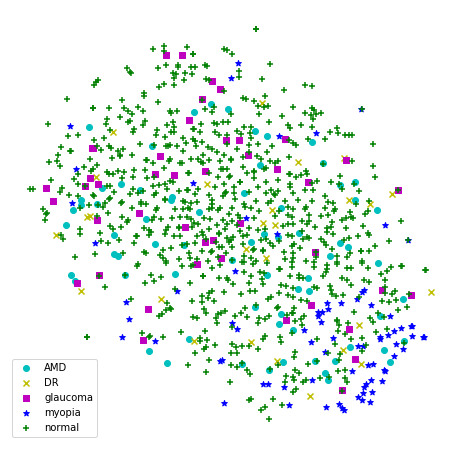

In [8]:
#visualize : t-SNE
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import random
def scatter(X, y):
    #X,y:numpy-array
    classes = len(list(set(y.tolist())))#get number of classes
    #palette = np.array(sns.color_palette("hls", classes))# choose a color palette with seaborn.
    color = ['c','y','m','b','g','r']
    marker = ['o','x','s','*','+']
    label = ['AMD','DR','glaucoma','myopia','normal']
    plt.figure(figsize=(8,8))#create a plot
    for i in range(classes):
        plt.scatter(X[y == i,0], X[y == i,1], c=color[i], marker=marker[i], label=label[i])
    plt.axis('off')
    plt.legend(loc='lower left')
    #plt.savefig('digits_tsne-generated.png', dpi=100)
    plt.show()

#prepare data，classes=5
#idx= random.sample(np.where(np.array(teY)==0)[0].tolist(),100)
idx= np.where(np.array(teY)==0)[0].tolist()
X0= np.array(teF)[idx]
y0= np.array(teY)[idx]

idx= np.where(np.array(teY)==1)[0].tolist()
X1= np.array(teF)[idx]
y1= np.array(teY)[idx]

idx= np.where(np.array(teY)==2)[0].tolist()
X2= np.array(teF)[idx]
y2= np.array(teY)[idx]

idx= np.where(np.array(teY)==3)[0].tolist()
X3= np.array(teF)[idx]
y3= np.array(teY)[idx]

idx= np.where(np.array(teY)==4)[0].tolist()
X4= np.array(teF)[idx]
y4= np.array(teY)[idx]

y = np.append(y0,y1)
y = np.append(y,y2)
y = np.append(y,y3)
y = np.append(y,y4)
X = np.vstack((X0,X1))
X = np.vstack((X,X2))
X = np.vstack((X,X3))
X = np.vstack((X,X4))
#training t-sne 
tsne = TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)
print("Org data dimension is {}.Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))

#visualize
scatter(X_tsne, y)

In [10]:
# generate class activation mapping for the top1 prediction
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    
    output_cam = []
    for idx in class_idx:
        #cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc,h*w)))
        cam = weight_softmax[class_idx]*(feature_conv.reshape((nc,h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
#last conv layer followed with one channel by last fully connected layer
final_conv = 'dense' 
best_net._modules.get(final_conv).register_forward_hook(hook_feature)
#get weights parameters
params = list(best_net.parameters())
#get the last and second last weights, like [classes, hiden nodes]
weight_softmax = np.squeeze(params[-2].data.cpu().numpy()) 
# define class type
classes = {0: 'AMD', 1: 'DR', 2:'glaucoma', 3:'myopia', 4:'norm'}
#read image
root='/data/fjsdata/fundus/iSee/iSee_multi_dataset/img_data_DR/913024.jpg'
img = []
img.append( cv2.resize(cv2.imread(root).astype(np.float32), (256, 256)))#(256, 256) is the model input size
data = torch.from_numpy(np.array(img)).type(torch.FloatTensor).cuda()
_,logit = best_net(data.permute(0, 3, 1, 2))#forword
h_x = F.softmax(logit, dim=1).data.squeeze()#softmax
probs, idx = h_x.sort(0, True) #probabilities of classes

# output: the prediction
for i in range(0, len(classes)):
    line = '{:.3f} -> {}'.format(probs[i], classes[idx[i].item()])
    print(line)
#get the class activation maps
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0].item()])

# render the CAM and show
print('output CAM.jpg for the top1 prediction: %s' % classes[idx[0].item()])
img = cv2.imread(root)
height, width, _ = img.shape
CAM = cv2.resize(CAMs[0], (width, height))
heatmap = cv2.applyColorMap(CAM, cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
#result = heatmap 
cv2.imwrite('iSee_cam.jpg', result)

0.523 -> norm
0.184 -> AMD
0.143 -> DR
0.076 -> myopia
0.074 -> glaucoma
output CAM.jpg for the top1 prediction: norm


True